# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
# откройте данные: ваш код здесь
import pandas as pd
df = pd.read_csv('spam_or_not_spam.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [2]:
# рассчитайте частоты для классов : ваш код здесь
freq_df = df['label'].value_counts()#/df.shape[0]
freq_df

0    2500
1     500
Name: label, dtype: int64

Text(0, 0.5, 'Доля писем')

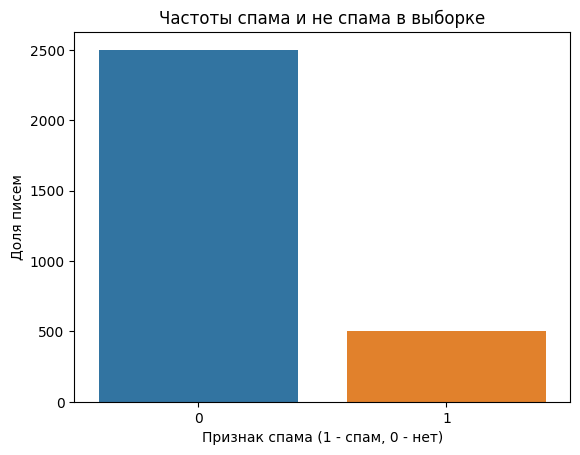

In [3]:
# визуализируйте результат: ваш код здесь
import seaborn as sns
bar = sns.barplot(x=freq_df.index, y = freq_df)
bar.set_title('Частоты спама и не спама в выборке')
bar.set_xlabel('Признак спама (1 - спам, 0 - нет)')
bar.set_ylabel('Доля писем')

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
df_clean = df.copy()

In [6]:
#ваш код здесь

#Строки из пробелов и всяких переносов и табуляций превращаем в ''
df_clean['email'] = df_clean['email'].str.replace('\s+', ' ', regex=True).str.strip() 

#Оставим непустые строки
df_clean = df_clean[df_clean['email'] != '']
#Уберем пропуски
df_clean = df_clean.dropna()


(2997, 2)

***На самом деле в этом месте я бы еще перевел все в нижний регистр и убрал знаки препинания, как делали с СМС в примере в модуле. Не буду делать это т.к. в задании этого не просят***

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_clean["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
#ваш код здесь
print(f'В наших данных теперь {X.shape[1]} признаков')

В наших данных теперь 34116 признаков


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
#ваш код здесь
# X у нас уже есть, так что определим y:
y = df_clean['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
#ваш код здесь
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
#ваш код здесь
print(f'Среднее значение целевой переменной по тестовой выборке = {y_test.mean()}')

Среднее значение целевой переменной по тестовой выборке = 0.16533333333333333


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
#ваш код здесь
#Нам навскидку подходят MultinomialNB, ComplementNB, BernoulliNB. Несложно уж и каждый обучить и посмотреть на каждом
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train) 

bnb = BernoulliNB(alpha=0.01)
bnb.fit(X_train, y_train) 

cnb = ComplementNB(alpha=0.01)
cnb.fit(X_train, y_train) 

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [13]:
#ваш код здесь
#Посмотрим на accuracy, precision и recall вот прям по классике. Выведем в виде таблички метрика/модель
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
columns = ['acc','pre','rec']
index = ['MultinomialNB','BernoulliNB','ComplementNB']
vals = np.zeros([3,3])

for i,model in enumerate([mnb,bnb,cnb]):
    y_test_pred = model.predict(X_test)
    vals[i,0] = accuracy_score(y_test_pred, y_test)
    vals[i,1] = precision_score(y_test_pred, y_test)
    vals[i,2] = recall_score(y_test_pred, y_test)

res_df = pd.DataFrame(vals, index=index, columns=columns)
res_df


,acc,pre,rec
MultinomialNB,0.986667,0.919355,1.0
BernoulliNB,0.973333,0.838710,1.0
ComplementNB,0.988000,0.927419,1.0


***Забавно, что ВСЕ спам письма были определены всеми моделями (recall=1), но все модели отнесли часть нормальных писем к спаму. Это кстати очень сходится с практикой пользования электронной почтой в жизни***

Нарисуйте ROC-кривую:

In [14]:
#ваш код здесь
#Лучшей кажется модель ComplementNB, так что кривую для нее будем рисовать и ее возьмем для дальнейших изысканий
#Второй момент - ROC кривую вроде мы не строили, строили PR-кривую, а это все же как я понял, несколько другая история. 
#Но мне кажется, там картинки должны соотносится в каком-то смысле, судя по описанию ROC-кривой. Пожтому построим и то и другое.

#Начнем со знакомой PR-кривой
y_test_proba_pred = cnb.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_pred)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba_pred)


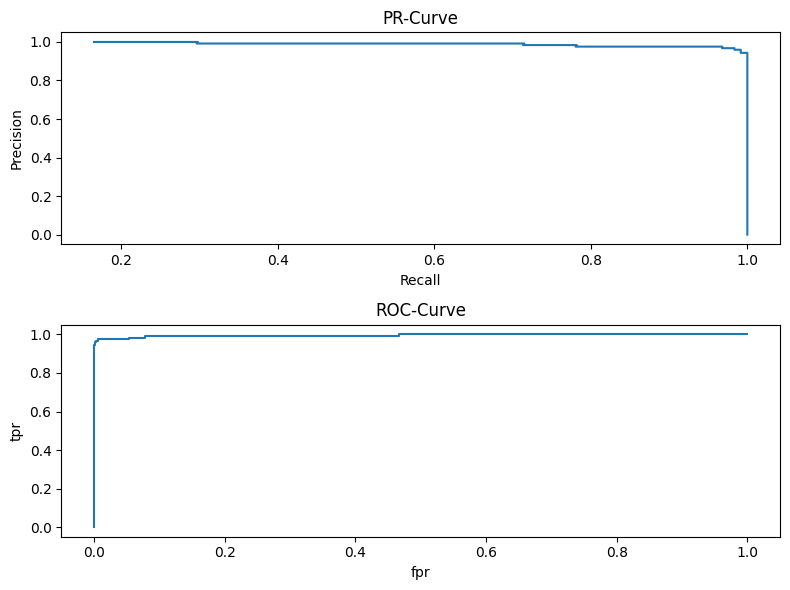

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,1,figsize=(8, 6)) #фигура + координатная плоскость

axes[0].plot(precision, recall, label='Decision Tree PR')
axes[0].set_title('PR-Curve')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')

axes[1].plot(fpr, tpr, label='Decision Tree PR')
axes[1].set_title('ROC-Curve')
axes[1].set_xlabel('fpr')
axes[1].set_ylabel('tpr')


plt.tight_layout()

***Кривые действительно похожи. И вообще, наш алгорити работает очень хорошо, судя по обеим кривым (площадь подграфиков обеих кривых близка к максимально возможной)***

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [16]:
#ваш код здесь
#Как итог, построим график зависимости 3х выбранных метрик от alpha
from sklearn import model_selection

result_list = [] #alpha, acc, pre, rec на обученных данных с помощью кросс-валидации

for alpha in np.linspace(0.01,2,100):
    model = ComplementNB(alpha=alpha)
    model.fit(X_train, y_train)
    skf = model_selection.StratifiedKFold(n_splits=5)
    y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict')
    result_list.append([alpha,accuracy_score(y_cv_proba_pred, y_train),
                        precision_score(y_cv_proba_pred, y_train),recall_score(y_cv_proba_pred, y_train)])
 
result_list = pd.DataFrame(result_list, columns= ['alpha','acc', 'pre', 'rec'])


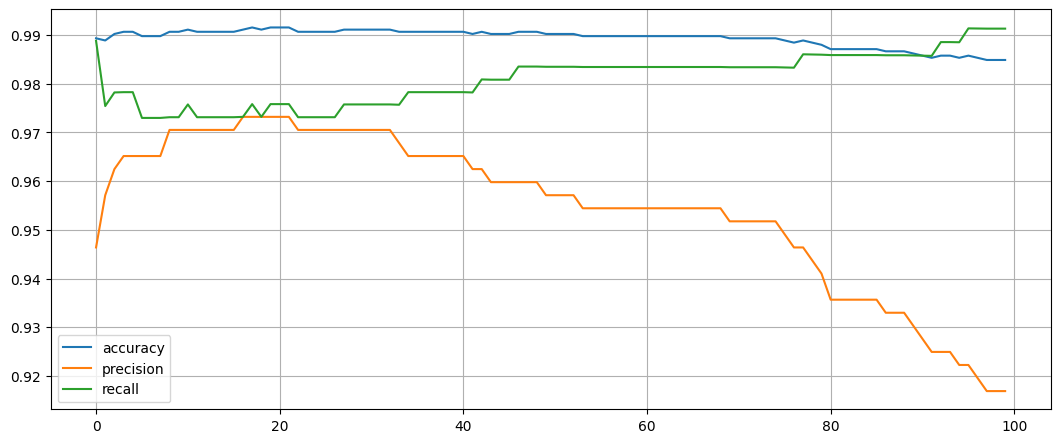

In [17]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(result_list['acc'], label='accuracy')
axes.plot(result_list['pre'], label='precision')
axes.plot(result_list['rec'], label='recall')
axes.legend()
axes.grid()


***ИНТЕРЕСНЫЕ НАБЛЮДЕНИЯ И ВЫВОДЫ ПО ЗАВИСИМОСТИ ОТ ALPHA***

1. *Вообще говоря, судя по всему увеличение alpha при наивной байесовской классификации увеличивает recall, и уменьшает precision. В этой задаче это так по крайней мере*
2. *Я бы выбирал для реальной задачи значение alpha = 0.375. На мой взгляд получаем сбалансированную модель, котора с максимальной вероятностью не положит в спам важные сообщения*
3. *И да, качество классификации зависит от alpha, по крайней мере очень существенно по метрике precision, которая на мой взгляд важна в данной задаче*